This notebook is part of the PyImageJ [Tutorial Series](./notebooks.rst), and assumes familiarity with the ImageJ API. Dedicated tutorials for ImageJ can be found [here](https://imagej.net/tutorials/).

# 7 Running macros, scripts and plugins

PyImageJ supports running ImageJ macros, scripts and plugins. Checkout the examples below to see how each function works.  First let's initialize ImageJ with Fiji so we can use some plugins.

In [1]:
import imagej

# initialize ImageJ2 with Fiji plugins
ij = imagej.init('sc.fiji:fiji')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.14.0/1.54f


## 7.1 Using ImageJ macros: `ij.py.run_macro`

Running an original ImageJ style macro is as simple as providing the macro code in a string, and the arguments in a dictionary to `ij.py.run_macro`. Modify the following cell to print your name, age, and city.

In [2]:
macro = """
#@ String name
#@ int age
#@ String city
#@output Object greeting
greeting = "Hello " + name + ". You are " + age + " years old, and live in " + city + "."
"""
args = {
    'name': 'Chuckles',
    'age': 13,
    'city': 'Nowhere'
}
result = ij.py.run_macro(macro, args)
print(result.getOutput('greeting'))

Operating in headless mode - the original ImageJ will have limited functionality.


[INFO] script:macro.ijm = [[greeting], [Hello Chuckles. You are 13 years old, and live in Nowhere.]]
Hello Chuckles. You are 13 years old, and live in Nowhere.


## 7.2 Using scripts: `ij.py.run_script`
Running scripts in other languages is similar, but you also have to specify the language extension (_e.g._ 'py', 'ijm', 'js') or the language name (_e.g._ 'python', 'IJ1 Macro', 'javascipt') for the scripting language it is written in. PyImageJ includes a convenience function to invoke such scripts from Python as well: `outputs = ij.py.run_script(language, script, args)`, where `args` is a dictionary of input variable names to values, and `outputs` is a dictionary of output variable names to values.

The following cell gives an example of such a script, written in [Groovy](https://imagej.net/scripting/groovy), which uses [ImageJ Ops](https://imagej.net/libs/imagej-ops) to compute numerical statistics about an image, returning the result as a [SciJava Table](https://github.com/imagej/tutorials/blob/2022-04/notebooks/1-Using-ImageJ/4-Tables.ipynb) object.

In [3]:
compute_stats_script = """
#@ OpService ops
#@ net.imglib2.RandomAccessibleInterval image
#@output stats

statNames = new org.scijava.table.GenericColumn("Statistic")
statValues = new org.scijava.table.DoubleColumn("Value")
addRow = (n, v) -> { statNames.add(n); statValues.add(v.getRealDouble()) }

addRow("geometricMean", ops.stats().geometricMean(image))
addRow("harmonicMean", ops.stats().harmonicMean(image))
addRow("kurtosis", ops.stats().kurtosis(image))
addRow("max", ops.stats().max(image))
addRow("mean", ops.stats().mean(image))
addRow("median", ops.stats().median(image))
addRow("min", ops.stats().min(image))
addRow("moment1AboutMean", ops.stats().moment1AboutMean(image))
addRow("moment2AboutMean", ops.stats().moment2AboutMean(image))
addRow("moment3AboutMean", ops.stats().moment3AboutMean(image))
addRow("moment4AboutMean", ops.stats().moment4AboutMean(image))
addRow("size", ops.stats().size(image))
addRow("skewness", ops.stats().skewness(image))
addRow("stdDev", ops.stats().stdDev(image))
addRow("sum", ops.stats().sum(image))
addRow("sumOfInverses", ops.stats().sumOfInverses(image))
addRow("sumOfLogs", ops.stats().sumOfLogs(image))
addRow("sumOfSquares", ops.stats().sumOfSquares(image))
addRow("variance", ops.stats().variance(image))

stats = new org.scijava.table.DefaultGenericTable()
stats.add(statNames)
stats.add(statValues)
"""

# load a sample image
image = ij.io().open('sample-data/test_image.tif')
args = {"image":image}
result = ij.py.run_script("Groovy", compute_stats_script, args)

# convert SciJava Table to pandas DataFrame
df = ij.py.from_java(result.getOutput("stats"))
print(df)

[INFO] stats = [[geometricMean, harmonicMean, kurtosis, max, mean, median, min, moment1AboutMean, moment2AboutMean, moment3AboutMean, moment4AboutMean, size, skewness, stdDev, sum, sumOfInverses, sumOfLogs, sumOfSquares, variance], [595.4414497753899, 577.0396027150354, 29.15435353004105, 5312.0, 620.693248, 533.0, 329.0, 3.836939868051558E-12, 46033.20548721019, 3.4518346475241706E7, 6.17816849886094E10, 62500.0, 3.4948837458522295, 214.55521907025008, 3.8793328E7, 108.31145679764538, 399331.44142784143, 2.69558321E10, 46033.94203028317]]
           Statistic               Value
0      geometricMean           595.44145
1       harmonicMean          577.039603
2           kurtosis           29.154354
3                max              5312.0
4               mean          620.693248
5             median               533.0
6                min               329.0
7   moment1AboutMean                 0.0
8   moment2AboutMean        46033.205487
9   moment3AboutMean     34518346.475242
10 

Finally, you might be wondering why we bothered to code this statistics-calculating logic as a Groovy script, when we could have simply written it directly in Python, thanks to the magic of PyImageJ. It's true, we did not need `run_script` here. But there are reasons you might want to use `run_script`:

1. If you have a pre-existing SciJava script, such as one stored in a file, `run_script` enables you to invoke it directly without translating it to Python.
2. When you call `run_script`, the entire script executes on the Java side in one shot, whereas the equivalent Python code would perform many calls across the Python/Java boundary, each of which takes some extra time and might fail due to bugs in PyImageJ/scyjava/JPype/etc. Therefore, depending on the situation, `run_script` might improve performance and/or correctness.
3. You might want to write a block of code in a different language besides Python.

## 7.3 Example: Run a plugin: `ij.py.run_plugin`

Finally, running plugins works in the same manner as macros. You simply enter the plugin name as a string and the arguments in a dict. For the few plugins that use ImageJ2 style macros (i.e., explicit booleans in the recorder), set the optional variable `ij1_style=False`.

This example works with original ImageJ windows, opening images entirely within ImageJ and then getting the results. Working with original ImageJ windows requires importing another class, which is done using the `jimport` function of scyjava.

In [4]:
ij.py.run_macro("""run("Blobs (25K)");""")
blobs = ij.WindowManager.getCurrentImage()
print(blobs)

Operating in headless mode - the WindowManager class will not be fully functional.


img["blobs.gif" (-3), 8-bit, 256x254x1x1x1]


Now let's view the blobs.

[INFO] blobs.gif = net.imagej.display.DefaultDatasetView@4e4f4092


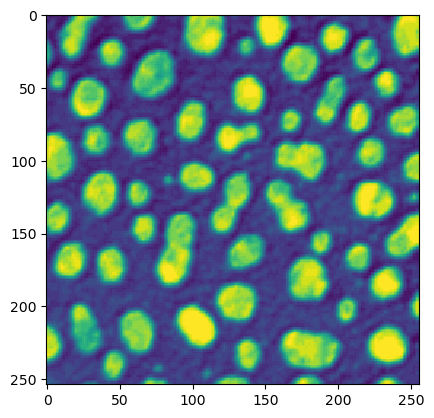

In [5]:
ij.py.show(blobs)

We can now run plugins that require open original ImageJ windows on blobs

In [6]:
# NB: This is not a built-in ImageJ command! It is the
# Plugins › Integral Image Filters › Mean command,
# which is part of mpicbg_, which is included with Fiji.
plugin = 'Mean'
args = { 
    'block_radius_x': 10,
    'block_radius_y': 10
}
ij.py.run_plugin(plugin, args)

Operating in headless mode - the IJ class will not be fully functional.


Next, obtain the current image from the `WindowManager` and display the results from the plugin.

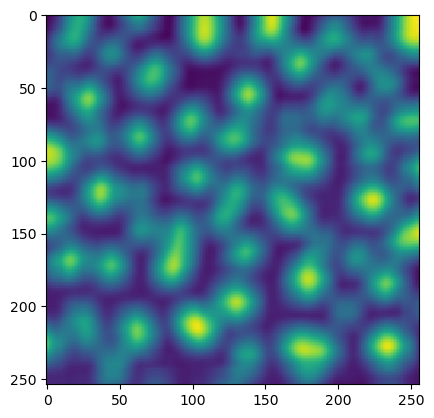

In [7]:
result = ij.WindowManager.getCurrentImage()
result = ij.py.show(result)

You can list any active original ImageJ windows with the following command.

In [8]:
print(type(ij.window().getOpenWindows()))

<java class 'java.util.Collections.UnmodifiableRandomAccessList'>


In [9]:
print(ij.window().getOpenWindows())

[stats, blobs.gif]


You can close any original ImageJ windows through the following command.

NOTE this is only true for ImageJ2's `WindowService`. Add info about the `WindowManager` and old school imagej stuff.

In [10]:
ij.window().clear()
print(ij.window().getOpenWindows())

[]
